# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

Применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/api_references/python_interface/artm_model.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создадим объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами).

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder="lectures_batches_v2", 
                                        batch_size=100)

##### Инициализация модели

Создадим объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# код
model_artm = artm.ARTM(num_topics=T, 
                       topic_names=topic_names, 
                       class_ids={"text":1, "author":1},
                       num_document_passes=1, 
                       reuse_theta=True, 
                       cache_theta=True, 
                       seed=1)
# число после названия модальностей - это их веса

Будем строить 29 предметных тем и одну фоновую. 

Создадим словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1.

In [6]:
# код
np.random.seed(1)  #похоже, это не очень нужно, уже учтено в предыдущем
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

##### Добавление score

Создадим два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. 

In [7]:
# код
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Подробнее [здесь](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавем сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
#  код
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SmoothPhi', 
        tau=1e5, 
        dictionary=dictionary, 
        class_ids=["text"], 
        topic_names="bcg"), 
    overwrite=True)

Выполним 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установим равным 1. 

In [9]:
%%time
#  код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)


Wall time: 24.1 s


Добавим разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
#  код
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SparsePhi', 
        tau=-1e5, 
        dictionary=dictionary, 
        class_ids=["text"], 
        topic_names=topic_names[:-1]), 
    overwrite=True)

Выполним еще 15 проходов по коллекции.

In [11]:
%%time
#  код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)


Wall time: 12.1 s


##### Интерпретация тем

Используя созданные score, выведим топы слов и топы авторов в темах. 

In [12]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens_text = model_artm.score_tracker["top_words_text"].last_tokens
    tokens_author = model_artm.score_tracker["top_words_author"].last_tokens
    print " ".join(tokens_text[topic_name])
    print " ".join(tokens_author[topic_name])
    print

sbj0:  частица взаимодействие физика кварк стандартный симметрия дмитрий элементарный нейтрино материя протон масса слабый фундаментальный построить
Дмитрий_Казаков Михаил_Данилов Валерий_Рубаков Сергей_Майоров Виктор_Брагута Павел_Пахлов Игорь_Волобуев Лев_Дудко Лев_Беклемишев Анатолий_Лиходед Эдуард_Боос Сергей_Троицкий Дэвид_Гросс Сергей_Гашков Жан-Арыс_Джилкибаев

sbj1:  материал структура температура свойство вещество химический соединение поверхность давление химия применение электронный углерод металл сверхпроводимость
Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Владимир_Пудалов Евгений_Гудилин Дмитрий_Гольберг Валентин_Крапошин Иван_Сорокин Наталья_Берлофф Дмитрий_Клинов Сергей_Морозов Евгений_Антипов Вадим_Бражкин Владимир_Комлев

sbj2:  политический государство политика власть царь партия положение труд правитель кризис враг ритуал средневековый сага борьба
Кирилл_Мартынов Алексей_Юдин Александр_Филиппов Михаил_Бойцов Дина_Гусейнова Иван_Ладынин Андрей_Лука

В последней теме "bcg" должны находиться общеупотребительные слова.


Дадим названия 29 предметным темам. 

In [13]:
sbj_topic_labels = [
   u"власть, церковь, Русь",
   u"астрономия", 
   u"система", 
   u"культура", 
   u"юридическое право", 
   u"материаловедение", 
   u"книги и кино", 
   u"общество и государство", 
   u"наука химия", 
   u"физика элементарных частиц", 
   u"россия и война", 
   u"становление человека", 
   u"медицина", 
   u"христианское государство", 
   u"астрофизика", 
   u"информация", 
   u"наука о расах", 
   u"политика и философия", 
   u"грамматика", 
   u"французская революция", 
   u"современные технологии", 
   u"медицина", 
   u"социология", 
   u"модели и общества", 
   u"мифология", 
   u"программирование", 
   u"экономика", 
   u"биология и генетика", 
   u"сверхпроводимость"
]
# запишим названия тем в список
topic_labels = sbj_topic_labels + [u"Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [14]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
#  код

theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids=["author"])

print theta.shape, phi_a.shape

(30, 1728) (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведим фрагмент theta как изображение.

C:\ProgramData\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


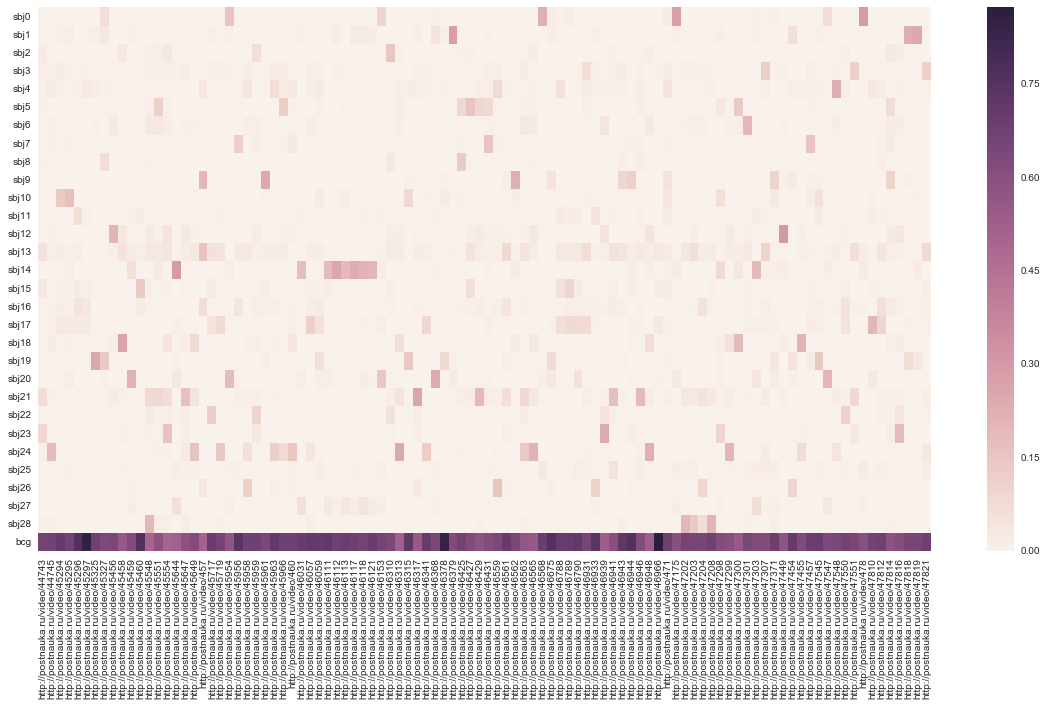

In [15]:
#  код
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.iloc[:,:100])

Видим, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. 
Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим так: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создадим переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведим датафрейм на печать.

In [16]:
#  код
pt = pd.DataFrame(theta.sum(axis=1).values / (theta.sum(axis=1).sum()), index=topic_labels)

In [17]:
pt

,0
"власть, церковь, Русь",0.012474
астрономия,0.017456
система,0.012020
культура,0.009385
юридическое право,0.011483
материаловедение,0.008314
книги и кино,0.009570
общество и государство,0.006454
наука химия,0.009189
физика элементарных частиц,0.008616


Для примера найдем 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную.

In [18]:
pt.sort_values(0)

,0
экономика,0.004685
общество и государство,0.006454
становление человека,0.006826
модели и общества,0.007889
материаловедение,0.008314
физика элементарных частиц,0.008616
сверхпроводимость,0.009079
наука химия,0.009189
культура,0.009385
книги и кино,0.009570


Визуализируем матрицу $\Phi$ модальности авторов в виде изображения. yticklabels=False в heatmap.

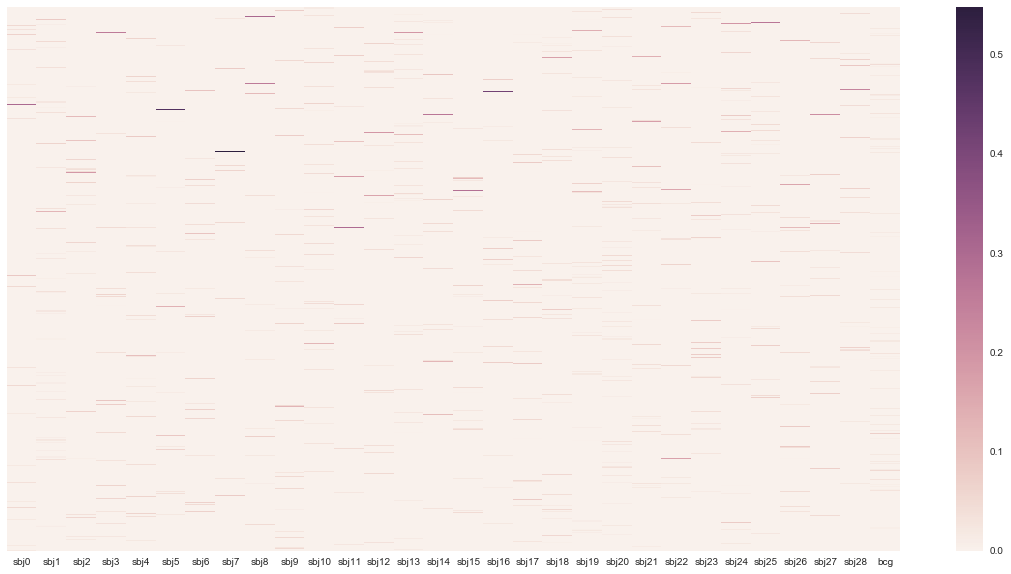

In [19]:
#  код
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитаем, в скольких темах он значим. Для примера найдем авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [20]:
num_theme = (phi_a > 0.01).sum(axis=1).sort_values(ascending=False)
num_theme[num_theme >= 3]

Мария_Фаликман           4
Михаил_Алексеевский      4
Илья_Иткин               4
Ян_Левченко              4
Александр_Пиперски       4
Ольга_Вайнштейн          4
Андрей_Чабовский         3
Николай_Дронин           3
Олег_Ауров               3
Александр_Филиппов       3
Александр_Тормасов       3
Павел_Нерлер_(Полян)     3
Анатолий_Баранов         3
Андрей_Журавлев          3
Константин_Мирошников    3
Фёдор_Успенский          3
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. 

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у нас есть и записаны в переменных phi и pt. 

Передадим матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используем косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [21]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [22]:
#  код
p_a = phi_a.values.dot(pt)

p_ta = (phi_a.values.T * pt.values) / p_a.T

In [23]:
p_ta.shape

(30L, 539L)

In [24]:
MDS_metod = MDS(dissimilarity="precomputed", random_state=321)
p_taT_pair_cos = pairwise_distances(p_ta[:-1, :].T, metric="cosine")
MDS_transformed_cos = MDS_metod.fit_transform(p_taT_pair_cos)

In [25]:
#MDS_transformed_cos[:5]

Визуализируем найденные двумерные представления с помощью функции scatter. 

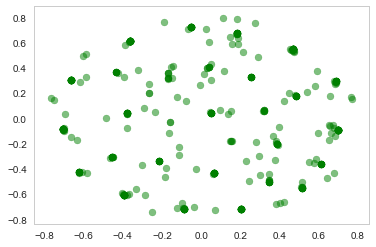

In [26]:
# Ваш код
plt.scatter(MDS_transformed_cos[:, 0],
            MDS_transformed_cos[:, 1], c='g', alpha=0.5)

Получилось, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. 

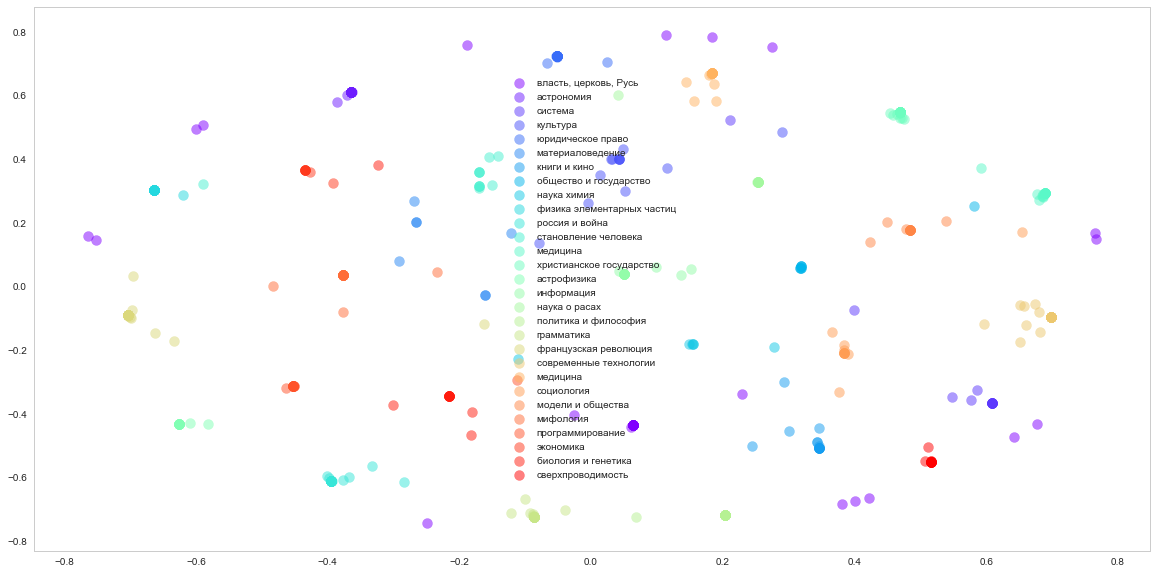

In [27]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T-1)) # цвета для тем
#  код
max_t_pta = p_ta[:-1, :].argmax(axis=0) # вычисляем номер наиболее вероятной темы для автора
plt.figure(figsize=(20, 10))
for y, c in enumerate(colors):
    plt.scatter(MDS_transformed_cos[max_t_pta==y][:, 0],
            MDS_transformed_cos[max_t_pta==y][:, 1], c=c, s=100, alpha=0.5, label=topic_labels[y])
    plt.legend()

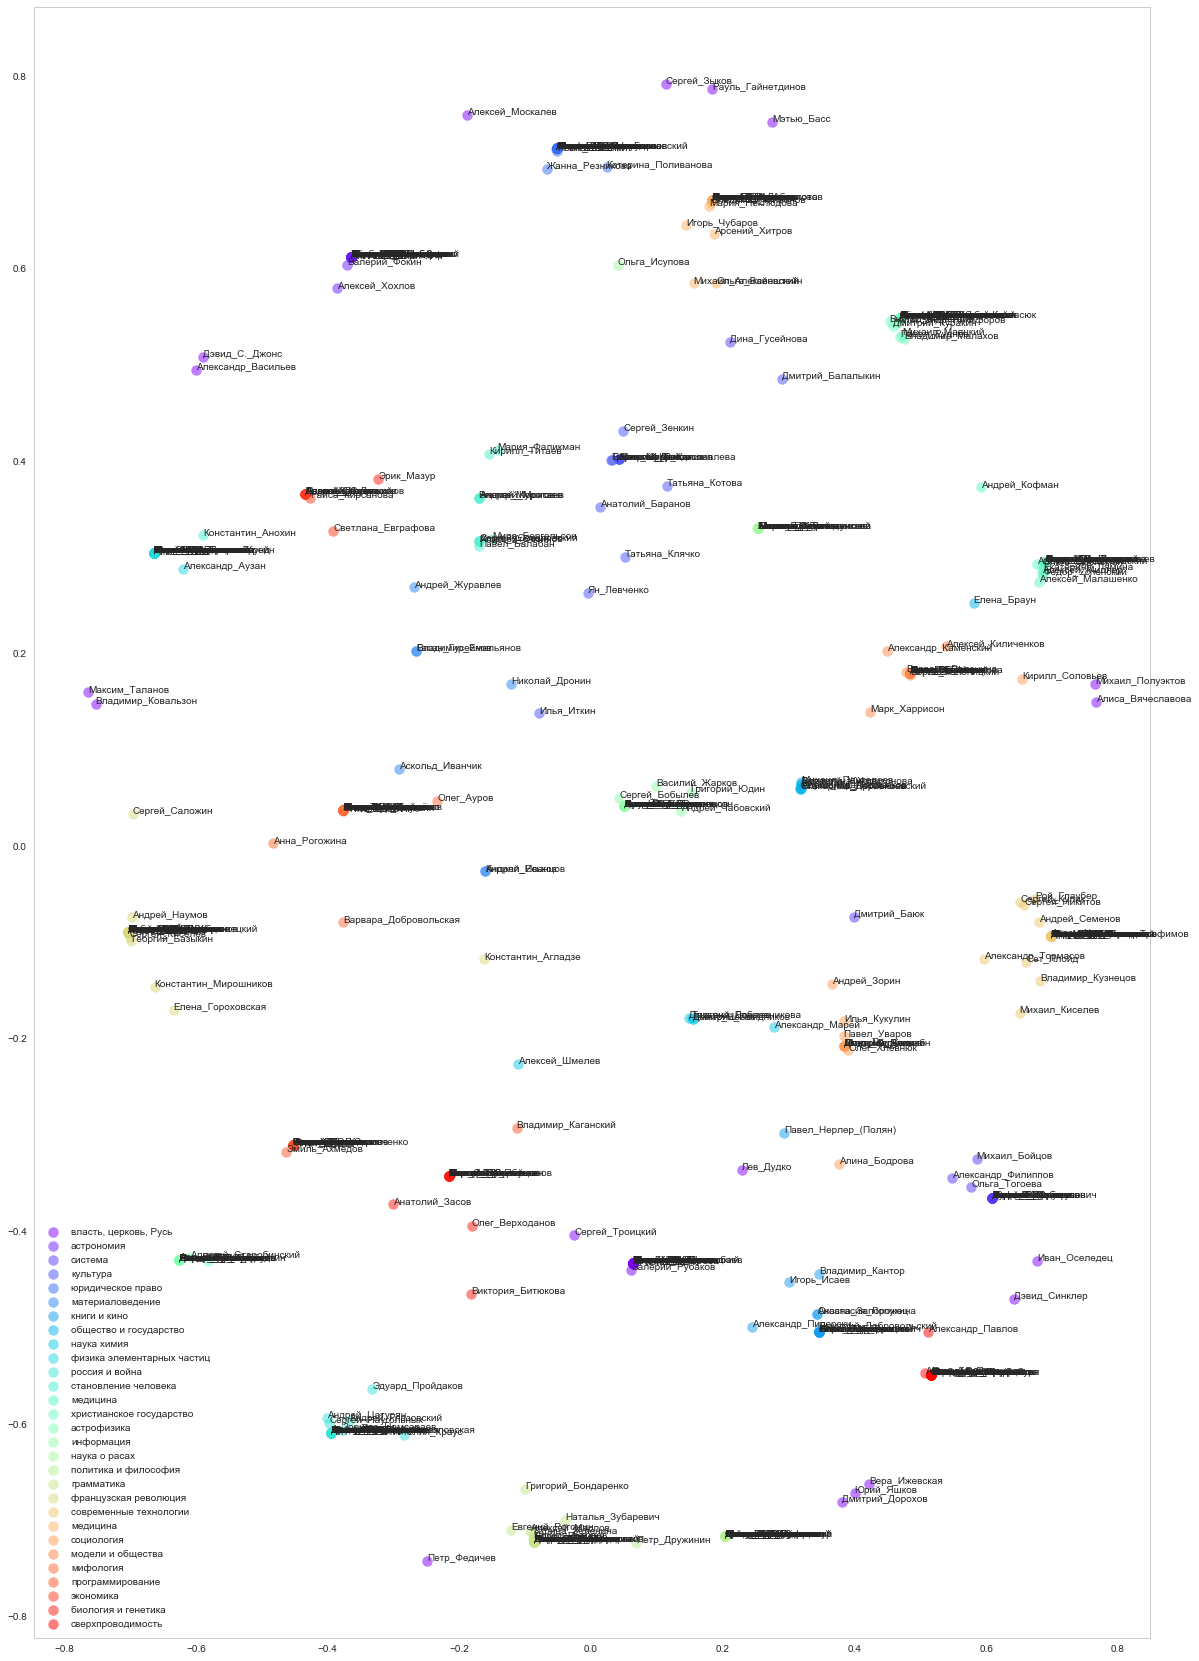

In [28]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T-1)) # цвета для тем
#  код
max_t_pta = p_ta[:-1, :].argmax(axis=0) # вычисляем номер наиболее вероятной темы для автора

fig = plt.figure(figsize=(20, 30))
for y, c in enumerate(colors):
    plt.scatter(MDS_transformed_cos[max_t_pta==y][:, 0],
            MDS_transformed_cos[max_t_pta==y][:, 1], c=c, s=100, alpha=0.5, label=topic_labels[y])
    plt.legend(loc='lower left')
for i in range(len(phi_a.index)):
    plt.annotate(phi_a.index[i], (MDS_transformed_cos[i, 0], MDS_transformed_cos[i, 1]))
plt.savefig('authors_map.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируем матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используем функцию argsort.

In [29]:
p_dt = theta / theta.sum(axis=0)

In [30]:
p_dt.shape

(30, 1728)

In [42]:
index = np.argsort(p_dt, axis=1).values

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [32]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [33]:
from IPython.core.display import display, HTML
display(HTML(u'<h1>Заголовок</h1>'))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))
display(HTML(u'<ul><li><a href="http://yandex.ru">http://yandex.ru</a></li></ul>'))

В цикле для каждой темы выведем ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используем html-разметку.

In [44]:
#  код

for i, topic_name in enumerate(model_artm.topic_names):
    display(HTML(u"<h1>{}</h1>".format(topic_labels[i])))   # также <h2>, <h3>
    display(HTML(u'<font color="green">{}</font>'.format(" ".join(tokens_text[topic_name]))))
    linklist = ['<li><a href="{}">{}</a></li>'.format(p_dt.columns[index[i, ind]], p_dt.columns[index[i, ind]]) 
                for ind in range(-1, -11, -1)]
    display(HTML(u"<ul>{}</ul>".format("".join(linklist))))

##### Заключение

В этом Peer Review мы отрабатывали возможности библиотеки BigARTM с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. 